# [Kaggle常用图片增强包 很好用!!!](https://github.com/aleju/imgaug)
## [效果展示案例](https://imgaug.readthedocs.io/en/latest/source/augmenters.html)

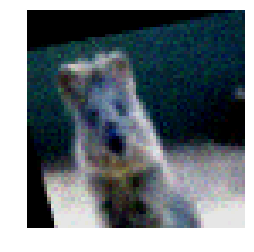

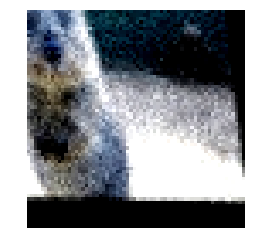

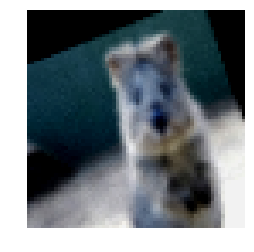

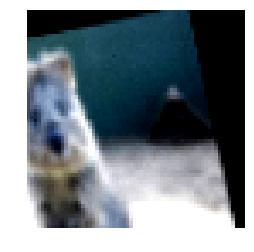

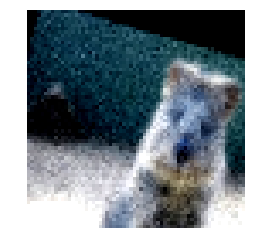

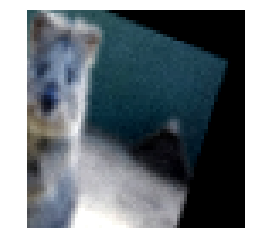

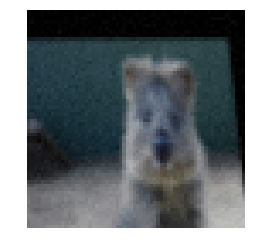

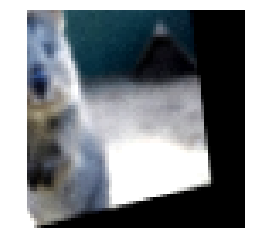

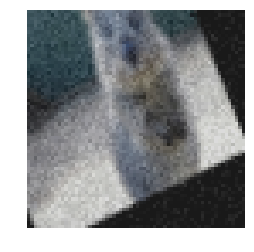

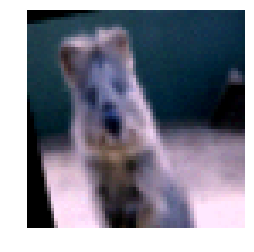

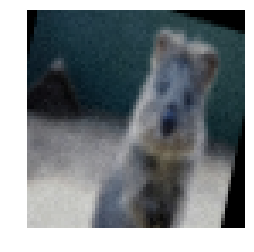

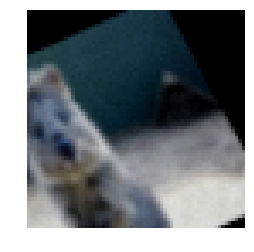

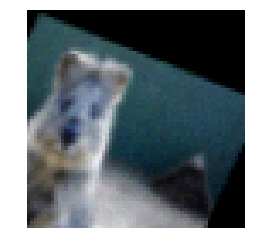

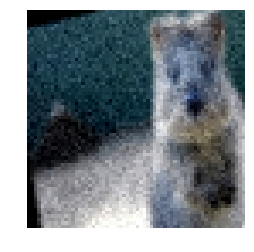

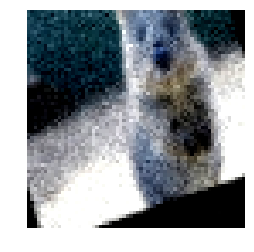

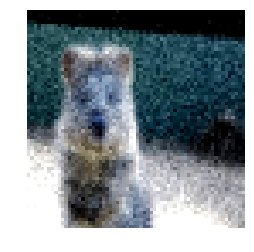

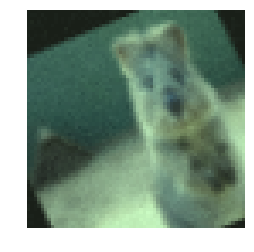

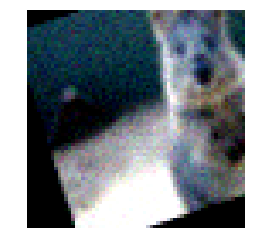

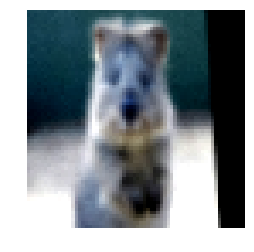

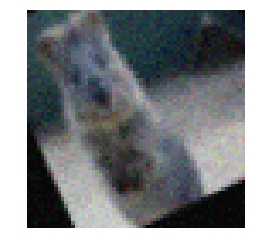

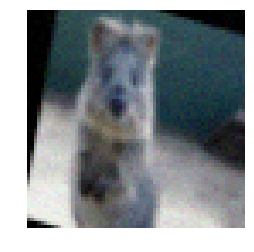

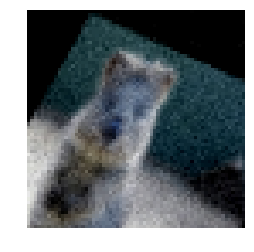

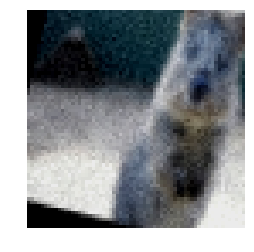

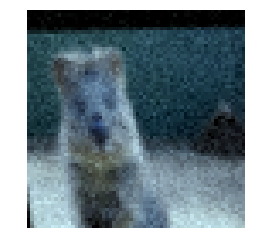

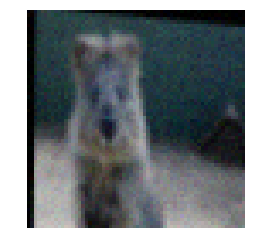

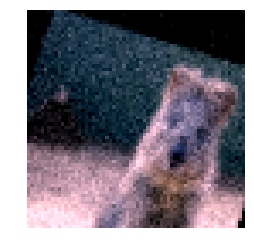

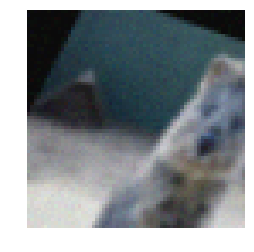

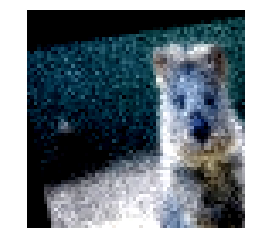

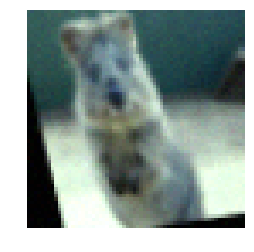

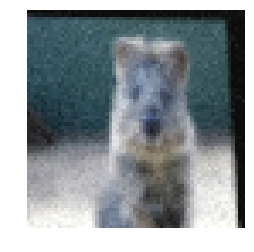

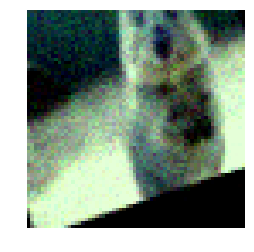

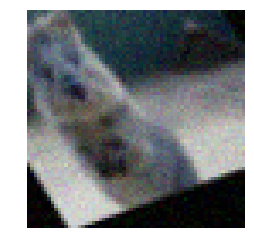

In [1]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

ia.seed(1)

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(32)],
    dtype=np.uint8
)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

images_aug = seq.augment_images(images)

# 显示增强后的效果
import matplotlib.pyplot as plt
plt.figure()
for i in range(images_aug.shape[0]):
    plt.imshow(images_aug[i])
    plt.axis('off')
    plt.show()
    

# 作者原实现 80epoch 水平翻转测试加权(0.011) 多阶段LR BCELoss

![](http://op4a94iq8.bkt.clouddn.com/18-9-2/22394851.jpg)

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split  # 分层分割数据集超方便的

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.preprocessing.image import load_img

/mnt/ml/anaconda35/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set some parameters
im_width = 101
im_height = 101
im_chan = 1

basicpath = ''
path_train = basicpath + 'TrainData/'
path_test = basicpath + 'TestData/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'

print("Training imgs path:",path_train_images)
print("Masks of training imgs path:",path_train_masks)
print("Test imgs path:",path_test_images)


Training imgs path: TrainData/images/
Masks of training imgs path: TrainData/masks/
Test imgs path: TestData/images/


In [3]:
img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

In [4]:
# Loading of training/testing ids and depths

train_df = pd.read_csv("train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("depths.csv", index_col="id")
train_df = train_df.join(depths_df) # 每个id链接上相应的深度
test_df = depths_df[~depths_df.index.isin(train_df.index)]

print("number of train：",len(train_df))
print(train_df.head(5))
print(depths_df.head(5))
test_df.head(5)

number of train： 4000
              z
id             
575d24d81d  843
a266a2a9df  794
75efad62c1  468
34e51dba6a  727
4875705fb0  797
              z
id             
4ac19fb269  306
1825fadf99  157
f59821d067  305
5b435fad9d  503
e340e7bfca  783


,z
id,
353e010b7b,264
5439dbbddf,557
71bab9f311,846
52551f7a80,610
512d8d9997,577


In [5]:
train_df["images"] = [np.array(load_img("TrainData/images/{}.png".format(idx), grayscale=True)) / 255
                              for idx in tqdm_notebook(train_df.index)]

train_df["masks"] = [np.array(load_img("TrainData/masks/{}.png".format(idx), grayscale=True))/ 255  
                              for idx in tqdm_notebook(train_df.index)]

A Jupyter Widget

/mnt/ml/anaconda35/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


A Jupyter Widget

In [6]:
train_df.head(10)

,z,images,masks
id,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
782ae9b7e7,677,"[[0.6078431372549019, 0.6196078431372549, 0.61...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
9842f69f8d,907,"[[0.4392156862745098, 0.4117647058823529, 0.4,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
aa94cfb806,754,"[[0.5058823529411764, 0.49019607843137253, 0.4...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
50d3073821,810,"[[0.4666666666666667, 0.5333333333333333, 0.41...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


In [7]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2) # 统计图片中像素为1的个数占整个图片101x101=10201个像素的比例

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)  #按照10%递增一档的比例进行阶梯分类

train_df.head(15)

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1
782ae9b7e7,677,"[[0.6078431372549019, 0.6196078431372549, 0.61...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0.225370,3
9842f69f8d,907,"[[0.4392156862745098, 0.4117647058823529, 0.4,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
aa94cfb806,754,"[[0.5058823529411764, 0.49019607843137253, 0.4...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0.665817,7
50d3073821,810,"[[0.4666666666666667, 0.5333333333333333, 0.41...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0.297030,3


/mnt/ml/anaconda35/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Coverage class')

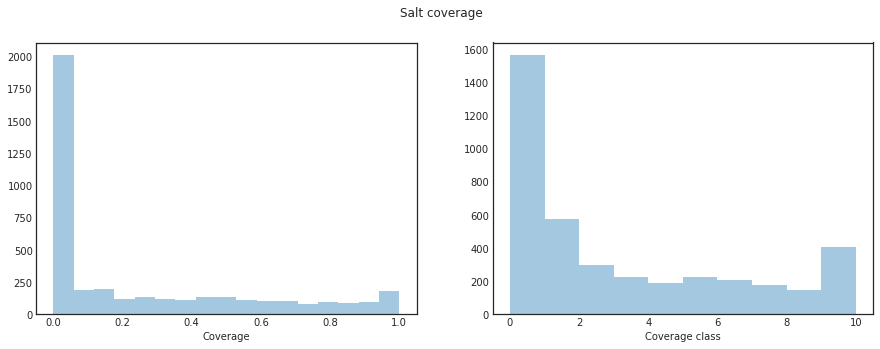

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

/mnt/ml/anaconda35/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Depth distribution')

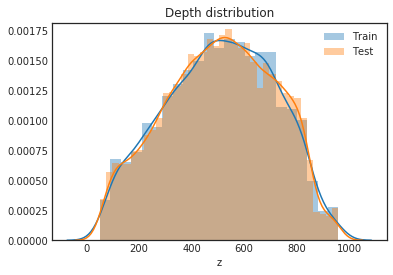

In [9]:
#Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [11]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), # [4000,101,101,1]
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), # [4000,101,101,1]
    train_df.coverage.values,# 4000个值
    train_df.z.values, # 4000个值
    test_size=0.05, stratify=train_df.coverage_class, random_state= 1234)  
# !!!! stratify 分层split的指标 覆盖比例的等级  后面还可以使用深度等级分层split

print(ids_train.shape)
print(x_train.shape)
print(y_train.shape)
print(cov_train.shape)
print(depth_train.shape)
type(x_train) # all are np.ndarray

(3800,)
(3800, 101, 101, 1)
(3800, 101, 101, 1)
(3800,)
(3800,)


numpy.ndarray

# 模型定义模块

In [1]:
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torch
from torchvision import models
import torchvision

In [2]:
# # 反卷积计算示例
# a_Deconv=nn.ConvTranspose2d(256,128,3,stride=2,\
#                                          padding=1,output_padding=1,bias=True, dilation=1)
# x=torch.randn(2,256,6,6)
# out=a_Deconv(x)
# out.shape

In [3]:

class Conv2D_block(nn.Module):
    def __init__(self,C_in,C_out,filter_size=3,paddingType="SAME",ActionType="Relu"):
        super().__init__()
        
        padding={}
        if filter_size==3:
            padding["SAME"]=1
        if filter_size==1:
            padding["SAME"]=0
        padding["VALID"]=0
        
        self.Conv=nn.Conv2d(C_in, C_out, filter_size, stride=1,padding=padding[paddingType])
        self.BN=nn.BatchNorm2d(C_out)
        self.ActionType=ActionType
        
    def forward(self,x):
        out=self.Conv(x)
        out=self.BN(out)
        if self.ActionType=="Relu":
            out=F.relu6(out,inplace=True)
        return out
            
class Residual_block(nn.Module):
    def __init__(self,C_in,C_out,filter_size=3,paddingType="SAME",ActionType="Relu"):
        super().__init__()
        
        self.BN=nn.BatchNorm2d(C_in)
        self.Conv1=Conv2D_block(C_in,C_out,filter_size,paddingType,ActionType)
        self.Conv2=Conv2D_block(C_out,C_out,filter_size,paddingType,ActionType=None)
        
    def forward(self,x):
        out=F.relu6(x,inplace=True)
        out=self.BN(out)
        out=self.Conv1(out)
        out=self.Conv2(out)
        out=out+x  # skip connection
        return out

class Eecoder_with_residual_block(nn.Module):
    
    def __init__(self,C_in,C_out,DropoutRatio = 0.5,filter_size=3,paddingType="SAME"):
        super().__init__()
        
        padding={}
        if filter_size==3:
            padding["SAME"]=1
        if filter_size==1:
            padding["SAME"]=0
        padding["VALID"]=0
        
        self.Conv_1=nn.Conv2d(C_in,C_out,filter_size,stride=1,padding=padding[paddingType])
        self.Res_1=Residual_block(C_out,C_out)
        self.Res_2=Residual_block(C_out,C_out)
    
    def forward(self,x):
        out=self.Conv_1(x)
        out=self.Res_1(out)
        out=self.Res_2(out)
        out=F.relu6(out,inplace=True)
        return out

class Decoder_with_residual_block(nn.Module):
    
    def __init__(self,C_in,C_out,DropoutRatio = 0.5,filter_size=3,paddingType="SAME"):
        super().__init__()
        
        padding={}
        if filter_size==3:
            padding["SAME"]=1
        if filter_size==1:
            padding["SAME"]=0
        padding["VALID"]=0  
        
        if paddingType=="VALID":
            output_padding=0
        else:
            output_padding=1
            
        self.Deconv_1=nn.ConvTranspose2d(C_in,C_out,filter_size, stride=2,\
                                         padding=padding[paddingType],output_padding=output_padding,bias=True, dilation=1)
        self.Dropout=nn.Dropout(DropoutRatio)
        self.Conv_1=nn.Conv2d(C_in,C_out,filter_size,stride=1,padding=1)
        self.Res_1=Residual_block(C_out,C_out)
        self.Res_2=Residual_block(C_out,C_out)
    
    def forward(self,x,skipx):
        out=self.Deconv_1(x)
        out=torch.cat([out,skipx],dim=1)
        out=self.Dropout(out)
        
        out=self.Conv_1(out)
        out=self.Res_1(out)
        out=self.Res_2(out)
        out=F.relu6(out,inplace=True)
        return out
        
class Middle_with_residual_block(nn.Module):
    
    def __init__(self,C_in,C_out,DropoutRatio = 0.5,filter_size=3,paddingType="SAME"):
        super().__init__()
        
        padding={}
        if filter_size==3:
            padding["SAME"]=1
        if filter_size==1:
            padding["SAME"]=0
        padding["VALID"]=0
            
        self.Conv_1=nn.Conv2d(C_in,C_out,filter_size,stride=1,padding=padding[paddingType])
        self.Res_1=Residual_block(C_out,C_out)
        self.Res_2=Residual_block(C_out,C_out)
       
    def forward(self,x):
        out=self.Conv_1(x)
        out=self.Res_1(out)
        out=self.Res_2(out)
        out=F.relu6(out,inplace=True)
        return out
    
class U_net_with_residual(nn.Module):
    
    def __init__(self,filter_num=16,DropoutRatio = 0.5,filter_size=3,paddingType="SAME"):
        super().__init__()
        
        self.Dropout_1=nn.Dropout(DropoutRatio/2)
        self.Dropout_2=nn.Dropout(DropoutRatio)
        im_chan=1
        self.Encoder_L1=Eecoder_with_residual_block(im_chan,filter_num,DropoutRatio/2)
        self.Encoder_L2=Eecoder_with_residual_block(filter_num*1,filter_num*2,DropoutRatio)
        self.Encoder_L3=Eecoder_with_residual_block(filter_num*2,filter_num*4,DropoutRatio)
        self.Encoder_L4=Eecoder_with_residual_block(filter_num*4,filter_num*8,DropoutRatio)
        
        self.Middle=Middle_with_residual_block(filter_num*8,filter_num*16,DropoutRatio)
        
        self.Decoder_L4=Decoder_with_residual_block(filter_num*16,filter_num*8,DropoutRatio,paddingType="SAME")
        self.Decoder_L3=Decoder_with_residual_block(filter_num*8,filter_num*4,DropoutRatio,paddingType="VALID")
        self.Decoder_L2=Decoder_with_residual_block(filter_num*4,filter_num*2,DropoutRatio,paddingType="SAME")
        self.Decoder_L1=Decoder_with_residual_block(filter_num*2,filter_num*1,DropoutRatio,paddingType="VALID")
        
    
        self.Out=nn.Conv2d(filter_num,1,1,stride=1,padding=0)
        
    def forward(self,x):
        Encoder_L1=self.Encoder_L1(x)
        Pool_L1=F.max_pool2d(Encoder_L1,2, stride=2)
        Pool_L1=self.Dropout_1(Pool_L1)
        
        Encoder_L2=self.Encoder_L2(Pool_L1)
        Pool_L2=F.max_pool2d(Encoder_L2,2, stride=2)
        Pool_L2=self.Dropout_2(Pool_L2)
        
        Encoder_L3=self.Encoder_L3(Pool_L2)
        Pool_L3=F.max_pool2d(Encoder_L3,2, stride=2)
        Pool_L3=self.Dropout_2(Pool_L3)
        
        Encoder_L4=self.Encoder_L4(Pool_L3)
        Pool_L4=F.max_pool2d(Encoder_L4,2, stride=2)
        Pool_L4=self.Dropout_2(Pool_L4)
        
        Middle=self.Middle(Pool_L4)
        
        Summary=True
        if Summary:
            print("1:",Encoder_L1.shape)
            print("2:",Encoder_L2.shape)
            print("3:",Encoder_L3.shape)
            print("4:",Encoder_L4.shape)
            print("Middle:",Middle.shape)
        
        
        Decoder_L4=self.Decoder_L4(Middle,Encoder_L4)
        Decoder_L3=self.Decoder_L3(Decoder_L4,Encoder_L3)
        Decoder_L2=self.Decoder_L2(Decoder_L3,Encoder_L2)
        Decoder_L1=self.Decoder_L1(Decoder_L2,Encoder_L1)
        
        if Summary:
            print("6:",Decoder_L4.shape)
            print("7:",Decoder_L3.shape)
            print("8:",Decoder_L2.shape)
            print("9:",Decoder_L1.shape)
            
        logits=self.Dropout_1(Decoder_L1)
        logits=self.Out(logits)
        loits=F.sigmoid(logits)
        
        if Summary:
            print("10:",logits.shape)
        
        return logits
        

In [4]:
import time 
since=time.time()

x=torch.randn(32,1,101,101)

model=U_net_with_residual(32)

if torch.cuda.is_available():
    x=x.cuda()
    model.cuda()
im_chan=1    
out=model(x)
print("cost time:",time.time()-since)

1: torch.Size([32, 32, 101, 101])
2: torch.Size([32, 64, 50, 50])
3: torch.Size([32, 128, 25, 25])
4: torch.Size([32, 256, 12, 12])
Middle: torch.Size([32, 512, 6, 6])
6: torch.Size([32, 256, 12, 12])
7: torch.Size([32, 128, 25, 25])
8: torch.Size([32, 64, 50, 50])
9: torch.Size([32, 32, 101, 101])
10: torch.Size([32, 1, 101, 101])
cost time: 7.8341615200042725


In [15]:
# #############################################
# ##  网络架构及Pytorch版本的Fine-tune手法   ##
# #############################################


# from torch import nn
# from torch.nn import functional as F
# import torch
# from torchvision import models
# import torchvision


# def conv3x3(in_, out):
#     return nn.Conv2d(in_, out, 3, padding=1)


# class ConvRelu(nn.Module):
#     def __init__(self, in_, out):
#         super().__init__()
#         self.conv = conv3x3(in_, out)
#         self.activation = nn.ReLU(inplace=True)

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.activation(x)
#         return x


# class DecoderBlock(nn.Module):
#     def __init__(self, in_channels, middle_channels, out_channels):
#         super().__init__()

#         self.block = nn.Sequential(
#             ConvRelu(in_channels, middle_channels),
#             nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.block(x)


# class UNet11(nn.Module):
#     def __init__(self, num_filters=32, pretrained=False):
#         """
#         :param num_classes:
#         :param num_filters:
#         :param pretrained:
#             False - no pre-trained network is used
#             True  - encoder is pre-trained with VGG11
#         """
#         super().__init__()
#         self.pool = nn.MaxPool2d(2, 2)

#         self.encoder = models.vgg11(pretrained=pretrained).features

#         self.relu = self.encoder[1]
#         #print(self.relu)   # output ==> RELU(inplace)
#         self.conv1 = self.encoder[0]
#         self.conv2 = self.encoder[3]
#         self.conv3s = self.encoder[6]
#         self.conv3 = self.encoder[8]
#         self.conv4s = self.encoder[11]
#         self.conv4 = self.encoder[13]
#         self.conv5s = self.encoder[16]
#         self.conv5 = self.encoder[18]

#         self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
#         self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
#         self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
#         self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
#         self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
#         self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)

#         self.final = nn.Conv2d(num_filters, 1, kernel_size=1)  # 1x1卷积 输出是1通道

#     def forward(self, x):
#         conv1 = self.relu(self.conv1(x))
#         conv2 = self.relu(self.conv2(self.pool(conv1)))
#         conv3s = self.relu(self.conv3s(self.pool(conv2)))
#         conv3 = self.relu(self.conv3(conv3s))
#         conv4s = self.relu(self.conv4s(self.pool(conv3)))
#         conv4 = self.relu(self.conv4(conv4s))
#         conv5s = self.relu(self.conv5s(self.pool(conv4)))
#         conv5 = self.relu(self.conv5(conv5s))

#         center = self.center(self.pool(conv5))

#         dec5 = self.dec5(torch.cat([center, conv5], 1))
#         dec4 = self.dec4(torch.cat([dec5, conv4], 1))
#         dec3 = self.dec3(torch.cat([dec4, conv3], 1))
#         dec2 = self.dec2(torch.cat([dec3, conv2], 1))
#         dec1 = self.dec1(torch.cat([dec2, conv1], 1))
#         return self.final(dec1)


# def unet11(pretrained=False, **kwargs):
#     """
#     pretrained:
#             False - no pre-trained network is used
#             True  - encoder is pre-trained with VGG11
#             carvana - all weights are pre-trained on
#                 Kaggle: Carvana dataset https://www.kaggle.com/c/carvana-image-masking-challenge
#     """
#     if pretrained== True:
#         model = UNet11(pretrained=pretrained, **kwargs)
#     else:
#         model= UNet11(pretrained=False, **kwargs)
    
#     #  根据 pretrained 加载 'carvana'数据集上训练好的网络全部权重
#     if pretrained == 'carvana':
#         state = torch.load('TernausNet.pt',map_location={'cuda:0': 'cpu'})  #
#         model.load_state_dict(state['model']) #,map_location='cpu'
        
#     return model


# class DecoderBlockV2(nn.Module):
#     def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
#         super(DecoderBlockV2, self).__init__()
#         self.in_channels = in_channels

#         if is_deconv:
#             """
#                 Paramaters for Deconvolution were chosen to avoid artifacts, following
#                 link https://distill.pub/2016/deconv-checkerboard/
#             """

#             self.block = nn.Sequential(
#                 ConvRelu(in_channels, middle_channels),
#                 nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
#                                    padding=1),
#                 nn.ReLU(inplace=True)
#             )
#         else:
#             self.block = nn.Sequential(
#                 nn.Upsample(scale_factor=2, mode='bilinear'),
#                 ConvRelu(in_channels, middle_channels),
#                 ConvRelu(middle_channels, out_channels),
#             )

#     def forward(self, x):
#         return self.block(x)


# class AlbuNet(nn.Module):
#     """
#         UNet (https://arxiv.org/abs/1505.04597) with Resnet34(https://arxiv.org/abs/1512.03385) encoder

#         Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/

#         """

#     def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
#         """
#         :param num_classes:
#         :param num_filters:
#         :param pretrained:
#             False - no pre-trained network is used
#             True  - encoder is pre-trained with resnet34
#         :is_deconv:
#             False: bilinear interpolation is used in decoder
#             True: deconvolution is used in decoder
#         """
#         super().__init__()
#         self.num_classes = num_classes

#         self.pool = nn.MaxPool2d(2, 2)

#         self.encoder = torchvision.models.resnet34(pretrained=pretrained)

#         self.relu = nn.ReLU(inplace=True)

#         self.conv1 = nn.Sequential(self.encoder.conv1,
#                                    self.encoder.bn1,
#                                    self.encoder.relu,
#                                    self.pool)

#         self.conv2 = self.encoder.layer1

#         self.conv3 = self.encoder.layer2

#         self.conv4 = self.encoder.layer3

#         self.conv5 = self.encoder.layer4

#         self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

#         self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
#         self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
#         self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
#         self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
#         self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
#         self.dec0 = ConvRelu(num_filters, num_filters)
#         self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

#     def forward(self, x):
#         conv1 = self.conv1(x)
#         conv2 = self.conv2(conv1)
#         conv3 = self.conv3(conv2)
#         conv4 = self.conv4(conv3)
#         conv5 = self.conv5(conv4)

#         center = self.center(self.pool(conv5))

#         dec5 = self.dec5(torch.cat([center, conv5], 1))

#         dec4 = self.dec4(torch.cat([dec5, conv4], 1))
#         dec3 = self.dec3(torch.cat([dec4, conv3], 1))
#         dec2 = self.dec2(torch.cat([dec3, conv2], 1))
#         dec1 = self.dec1(dec2)
#         dec0 = self.dec0(dec1)

#         if self.num_classes > 1:
#             x_out = F.log_softmax(self.final(dec0), dim=1)
#         else:
#             x_out = self.final(dec0)

#         return x_out


# class UNet16(nn.Module):
#     def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
#         """
#         :param num_classes:
#         :param num_filters:
#         :param pretrained:
#             False - no pre-trained network used
#             True - encoder pre-trained with VGG16
#         :is_deconv:
#             False: bilinear interpolation is used in decoder
#             True: deconvolution is used in decoder
#         """
#         super().__init__()
#         self.num_classes = num_classes

#         self.pool = nn.MaxPool2d(2, 2)

#         self.encoder = torchvision.models.vgg16(pretrained=pretrained).features

#         self.relu = nn.ReLU(inplace=True)

#         self.conv1 = nn.Sequential(self.encoder[0],
#                                    self.relu,
#                                    self.encoder[2],
#                                    self.relu)

#         self.conv2 = nn.Sequential(self.encoder[5],
#                                    self.relu,
#                                    self.encoder[7],
#                                    self.relu)

#         self.conv3 = nn.Sequential(self.encoder[10],
#                                    self.relu,
#                                    self.encoder[12],
#                                    self.relu,
#                                    self.encoder[14],
#                                    self.relu)

#         self.conv4 = nn.Sequential(self.encoder[17],
#                                    self.relu,
#                                    self.encoder[19],
#                                    self.relu,
#                                    self.encoder[21],
#                                    self.relu)

#         self.conv5 = nn.Sequential(self.encoder[24],
#                                    self.relu,
#                                    self.encoder[26],
#                                    self.relu,
#                                    self.encoder[28],
#                                    self.relu)

#         self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

#         self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
#         self.dec4 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
#         self.dec3 = DecoderBlockV2(256 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
#         self.dec2 = DecoderBlockV2(128 + num_filters * 2, num_filters * 2 * 2, num_filters, is_deconv)
#         self.dec1 = ConvRelu(64 + num_filters, num_filters)
#         self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

#     def forward(self, x):
#         conv1 = self.conv1(x)
#         conv2 = self.conv2(self.pool(conv1))
#         conv3 = self.conv3(self.pool(conv2))
#         conv4 = self.conv4(self.pool(conv3))
#         conv5 = self.conv5(self.pool(conv4))

#         center = self.center(self.pool(conv5))

#         dec5 = self.dec5(torch.cat([center, conv5], 1))

#         dec4 = self.dec4(torch.cat([dec5, conv4], 1))
#         dec3 = self.dec3(torch.cat([dec4, conv3], 1))
#         dec2 = self.dec2(torch.cat([dec3, conv2], 1))
#         dec1 = self.dec1(torch.cat([dec2, conv1], 1))

#         if self.num_classes > 1:
#             x_out = F.log_softmax(self.final(dec1), dim=1)
#         else:
#             x_out = self.final(dec1)

#         return x_out


# 指标计算

In [16]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    # Jiaxin fin that if all zeros, then, the background is treated as object
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in > 0.5 # added by sgx 20180728
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    #print("this batch metric = ",metric)
    return np.mean(metric)

def my_iou_metric(label, pred):
    '''
    tf.py_func接收的是tensor，然后将其转化为numpy array送入func函数，最后再将func函数输出的numpy array转化为tensor返回。
    ref: https://blog.csdn.net/tiankongtiankong01/article/details/80568311
    '''
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float64)
    return metric_value

# 准备训练数据并训练

In [17]:
#Data augmentation
x_train2 = np.transpose(np.append(x_train, [np.fliplr(x) for x in x_train], axis=0),(0,3,1,2)).astype(np.float32)
y_train2 = np.transpose(np.append(y_train, [np.fliplr(x) for x in y_train], axis=0),(0,3,1,2)).astype(np.float32)
x_valid2 = np.transpose(x_valid,(0,3,1,2)).astype(np.float32)
y_valid2 = np.transpose(y_valid,(0,3,1,2)).astype(np.float32)

print(x_train2.shape)
print(y_train2.shape)
print(x_valid2.shape)
print(y_valid2.shape)  # !!!不要对valid进行数据增强
print(type(x_train2[0,0,0,0]))
print(type(x_valid2[0,0,0,0]))

(7600, 1, 101, 101)
(7600, 1, 101, 101)
(200, 1, 101, 101)
(200, 1, 101, 101)
<class 'numpy.float32'>
<class 'numpy.float32'>


In [18]:
# 自定义一个Pytorch的数据加载器,必须继承自torch.utils.data.Dataset
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader

class saltIDDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

In [19]:
salt_ID_dataset_train = saltIDDataset(x_train2, 
                                      train=True, 
                                      preprocessed_masks=y_train2)

salt_ID_dataset_val = saltIDDataset(x_valid2, 
                                      train=True, 
                                      preprocessed_masks=y_valid2)

batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

print("Trainng samples:",train_loader.dataset.__len__())
print("Validation samples:",val_loader.dataset.__len__())

Trainng samples: 7600
Validation samples: 200


In [20]:
class ArgParser(object):
    def __init__(self):
        
        self.MaxEpoch=150
        self.LR_Policy="MultiStage"
        
        self.n_gpus=1
        
        self.load_pretrained_model=False
        self.pretarined_model_path="Results"
        
        self.device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.start_save_epoch=30
        self.save_step=20

In [22]:
import time
import shutil
        
def custom_weights_init(m):
    pass 

def save_checkpoint(state, is_best, path,args):
    save_path=os.path.join(path,'saved_Gpu_model_state.pt')
    torch.save(state, save_path)
    if is_best:
        shutil.copyfile(save_path, 
                        os.path.join(args.pretarined_model_path ,'best_Gpu_model_state.pt'))

def LearningRateAdjust(LR_Policy,optimizer,cur_epoch,history_metirc):
    if LR_Policy=="MultiSatge":
        if cur_epoch==1:
            lr=0.001
        elif cur_epoch<=9:
            lr=(cur_epoch)*0.001
        elif cur_epoch==10:
            lr=0.01
        elif cur_epoch==80:
            lr=0.003
        elif cur_epoch==110:
            lr=0.001
        elif cur_epoch==130:
            lr=0.0001
        elif cur_epoch==140:
            lr=0.00001
        else:
            return
        
        for param_group in optimizer.param_groups:
            param_group["lr"]=lr
    
def train(model,train_loader,optimizer,criterion,args,epoch,class_weights):
    since=time.time()
    model.train()
    train_losses = []
    
    for batch_idx, (images, masks) in enumerate(train_loader):
        
        images, masks = images.to(args.device), masks.to(args.device)
        images, masks = Variable(images), Variable(masks)
        
        logits = model(images)
        
        loss = criterion(logits, masks)
        train_losses.append(loss.data)
        
        #dice_loss = bioloss.dice_error(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         if batch_idx%20==0:
#             now=time.time()
#             print("Loss:{},escaped time:{}".format(loss,now-since))
#             since=now
#             #break
            
    now=time.time()
    mean_loss=np.mean(train_losses)
    print("Mean Train Loss:{},escaped time:{}".format(mean_loss,now-since))
    return mean_loss

def test(model,test_loader,criterion,args,epoch,class_weights):
    since=time.time()
    model.eval()
    test_losses = []
    
    for batch_idx, (images, masks) in enumerate(test_loader):
        
        images, masks = images.to(args.device), masks.to(args.device)
        images, masks = Variable(images), Variable(masks)
        
        logits = model(images)
        
        loss = criterion(logits, masks)
        test_losses.append(loss.data)
        #dice_loss = bioloss.dice_error(output, target)
        
    now=time.time()
    mean_loss=np.mean(test_losses)
    print("Mean Val Loss:{},escaped time:{}".format(mean_loss,now-since))
            
    return mean_loss
   
train_losses_history=[]
val_losses_history=[]

def main():
    
    args=ArgParser()
    
    torch.cuda.manual_seed_all(4200)# 设置全局固定随机种子方便复现
    np.random.seed(133700)
    
    model=U_net_with_residual(16) # 16 is the basic filter_nums, for controlling the width of U-Net
    
#     gpu_ids=range(args.n_gpus)
#     model=nn.parallel.DataParallel(model,device_ids=gpu_ids)
    
    if args.load_pretrained_model==True:
        state=torch.load(args.pretarined_model_path)
        model.load_state_dict(state)
    else:
        model.apply(custom_weights_init)    
    
    # deploy model to GPU or CPU
    model.to(args.device)
    
    # -------------------------------------------------------------------------------- #
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.BCEWithLogitsLoss()
    # -------------------------------------------------------------------------------- #
    
    
    
    class_weights=[0.5,0.5] 
    
    best_metric=100  # 注意指标的大小与性能的关系
    metirc_history=[]
    for epoch in range(1,args.MaxEpoch):
        LearningRateAdjust(args.LR_Policy,optimizer,epoch,metirc_history)
        
        mean_train_loss_=train(model,train_loader,optimizer,criterion,args,epoch,class_weights)
        train_losses_history.append(mean_train_loss_)
        
        mean_val_loss_=test(model,val_loader,criterion,args,epoch,class_weights)
        val_losses_history.append(mean_val_loss_)
        
        if  epoch>=args.start_save_epoch :
            if mean_val_loss_<best_metric:
                best_metric=mean_val_loss_
                is_best=True
                save_checkpoint(model.state_dict(), is_best, args.pretarined_model_path,args)
            else:
                is_best=False
                if epoch % args.save_step ==0:
                    save_path=os.path.join(args.pretarined_model_path,str(epoch))
                    if not os.path.exists(save_path):
                        os.mkdir(save_path)
                    save_checkpoint(model.state_dict(), is_best, save_path, args)
                    
    torch.save(model.state_dict(),"Results/mm.pt")
    return model

   
    

In [23]:
model=main() # 模型运行时间和申请到的GPU新旧有关 第一次运行一个epoch只需要21s 

Mean Train Loss:0.4371815025806427,escaped time:25.60692286491394
Mean Val Loss:0.5126643776893616,escaped time:0.17615938186645508
Mean Train Loss:0.32789894938468933,escaped time:25.561105966567993
Mean Val Loss:0.48280787467956543,escaped time:0.17076730728149414
Mean Train Loss:0.27714863419532776,escaped time:25.548023462295532
Mean Val Loss:0.4085845351219177,escaped time:0.17035651206970215
Mean Train Loss:0.2509693205356598,escaped time:25.53965663909912
Mean Val Loss:0.24409495294094086,escaped time:0.17358636856079102
Mean Train Loss:0.24675996601581573,escaped time:25.542104721069336
Mean Val Loss:0.21432256698608398,escaped time:0.17036175727844238
Mean Train Loss:0.22237947583198547,escaped time:25.53951096534729
Mean Val Loss:0.21166977286338806,escaped time:0.17044568061828613
Mean Train Loss:0.2101030796766281,escaped time:25.534651279449463
Mean Val Loss:0.1958024501800537,escaped time:0.18080735206604004
Mean Train Loss:0.2052842080593109,escaped time:25.5322561264038

Mean Train Loss:0.10873997956514359,escaped time:25.511172771453857
Mean Val Loss:0.14666520059108734,escaped time:0.17061614990234375
Mean Train Loss:0.11038095504045486,escaped time:25.511362314224243
Mean Val Loss:0.12368763238191605,escaped time:0.1728062629699707
Mean Train Loss:0.1104976087808609,escaped time:25.51087522506714
Mean Val Loss:0.14632607996463776,escaped time:0.17017865180969238
Mean Train Loss:0.10909516364336014,escaped time:25.513333559036255
Mean Val Loss:0.0975080132484436,escaped time:0.1734464168548584
Mean Train Loss:0.10476918518543243,escaped time:25.51248526573181
Mean Val Loss:0.1260307878255844,escaped time:0.17163586616516113
Mean Train Loss:0.10291053354740143,escaped time:25.512425422668457
Mean Val Loss:0.11527801305055618,escaped time:0.1773226261138916
Mean Train Loss:0.10627289861440659,escaped time:25.507161855697632
Mean Val Loss:0.09914364665746689,escaped time:0.1698169708251953
Mean Train Loss:0.09771556407213211,escaped time:25.502748727798

Mean Train Loss:0.08863415569067001,escaped time:25.512115001678467
Mean Val Loss:0.1044313833117485,escaped time:0.16978907585144043
Mean Train Loss:0.08994211256504059,escaped time:25.51044249534607
Mean Val Loss:0.11047327518463135,escaped time:0.16975855827331543
Mean Train Loss:0.09371182322502136,escaped time:25.508047580718994
Mean Val Loss:0.11024291068315506,escaped time:0.17014694213867188
Mean Train Loss:0.08736585080623627,escaped time:25.51256012916565
Mean Val Loss:0.10469009727239609,escaped time:0.17456626892089844
Mean Train Loss:0.08791098743677139,escaped time:25.50297451019287
Mean Val Loss:0.09696900844573975,escaped time:0.17060375213623047
Mean Train Loss:0.09904374927282333,escaped time:25.508434772491455
Mean Val Loss:0.0898362323641777,escaped time:0.16974735260009766
Mean Train Loss:0.0888596698641777,escaped time:25.514506101608276
Mean Val Loss:0.10742972791194916,escaped time:0.17003369331359863
Mean Train Loss:0.09157828241586685,escaped time:25.513191938

In [25]:
torch.save(model.state_dict(),"Results/mm.pt")

# 加载最优模型

In [55]:
import os

model=U_net_with_residual(16)

state = torch.load('Results/mm.pt')#,map_location={'cuda:0': 'cpu'})  #
model.load_state_dict(state) #,map_location='cpu'
model=model.cuda()


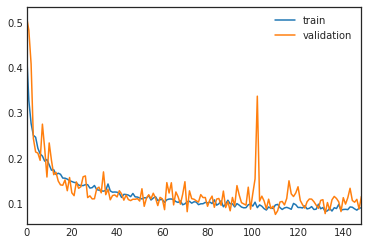

In [56]:
train_loss_series = pd.Series(train_losses_history)
val_loss_series = pd.Series(val_losses_history)
train_loss_series.plot(label="train")
val_loss_series.plot(label="validation")
plt.legend()

![](http://op4a94iq8.bkt.clouddn.com/18-9-3/31054653.jpg)

In [57]:
mask_pred_valid = []
mask_truth_valid=[]

for images, masks in train_loader:
    images = Variable(images.cuda())
#     images = Variable(images)
    y_preds = model(images)
    
    for i, _ in enumerate(images):
        y_pred = y_preds[i] 
        y_pred = y_pred.cpu().data.numpy()
        mask_pred_valid.append(y_pred)
        mask_truth_valid.append(masks[i].numpy())
        
        
mask_pred_valid=np.array(mask_pred_valid)
mask_truth_valid=np.array(mask_truth_valid)       
print(mask_truth_valid.shape)
print(mask_truth_valid.shape)

(7600, 1, 101, 101)
(7600, 1, 101, 101)


In [58]:
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(mask_truth_valid, np.int32(mask_pred_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

A Jupyter Widget

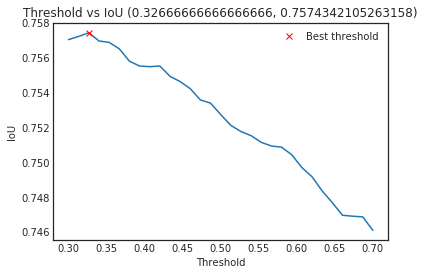

In [59]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# 准备测试数据并测试

In [60]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [61]:
x_test = np.array([(np.array(load_img("TestData/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

A Jupyter Widget

/mnt/ml/anaconda35/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [62]:
x_test.shape

(18000, 101, 101, 1)

In [63]:
x_test2=np.transpose(x_test,(0,3,1,2)).astype(np.float32)
print(x_test2.shape)
y_test2=np.zeros_like(x_test2).astype(np.float32)

salt_ID_dataset_test = saltIDDataset(x_test2, 
                                      train=True, 
                                      preprocessed_masks=y_test2)

batch_size = 32

test_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_test, 
                                           batch_size=batch_size, 
                                           shuffle=False)

(18000, 1, 101, 101)


In [64]:
x_test_Sym=np.transpose(np.array([np.fliplr(x) for x in x_test]),(0,3,1,2)).astype(np.float32)
print(x_test_Sym.shape)

y_test_Sym=np.zeros_like(x_test_Sym).astype(np.float32)

salt_ID_dataset_test_Sym = saltIDDataset(x_test_Sym, 
                                      train=True, 
                                      preprocessed_masks=y_test_Sym)

batch_size = 32

test_loader_Sym = torch.utils.data.DataLoader(dataset=salt_ID_dataset_test_Sym, 
                                           batch_size=batch_size, 
                                           shuffle=False)

(18000, 1, 101, 101)


In [65]:
mask_pred_test_Sym = []

for images, masks in test_loader_Sym:
    images = Variable(images.cuda())
#     images = Variable(images)
    y_preds = model(images)
    
    for i, _ in enumerate(images):
        y_pred = y_preds[i] 
        y_pred = y_pred.cpu().data.numpy()
        mask_pred_test_Sym.append(y_pred[:,:,::-1])
       
        
        
mask_pred_test_Sym=np.array(mask_pred_test_Sym) 
print(mask_pred_test_Sym.shape)


(18000, 1, 101, 101)


In [66]:
mask_pred_test = []

for images, masks in test_loader:
    images = Variable(images.cuda())
#     images = Variable(images)
    y_preds = model(images)
    
    for i, _ in enumerate(images):
        y_pred = y_preds[i] 
        y_pred = y_pred.cpu().data.numpy()
        mask_pred_test.append(y_pred)
       

        
mask_pred_test=np.array(mask_pred_test) 
print(mask_pred_test.shape)
mask_pred_test=0.5*(mask_pred_test+mask_pred_test_Sym)

(18000, 1, 101, 101)


In [67]:
import time
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(downsample(mask_pred_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

A Jupyter Widget


Usedtime = 5.481457710266113 s


In [68]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_solution5.csv')